# CSD 6: Regression: Linear and RF

1. In this Case Study assignment we will try to model and predict the price of a shirt by its title, using the [Bag Of Words](https://en.wikipedia.org/wiki/Bag-of-words_model) approach.

    Let's load the CSV files holding the training and test shirts titles and prices, and concatenate them to two big pandas DataFrames, `train_df` and `test_df`:

In [44]:
import pandas as pd

folder = '../../datasets/ebay_boys_girls_shirts/'
boys_train_df = pd.read_csv(folder + 'boys_train.csv')
boys_test_df = pd.read_csv(folder + 'boys_test.csv')
girls_train_df = pd.read_csv(folder + 'girls_train.csv')
girls_test_df = pd.read_csv(folder + 'girls_test.csv')

train_df = pd.concat([boys_train_df, girls_train_df])
test_df = pd.concat([boys_test_df, girls_test_df])

print(train_df.shape)
print(test_df.shape)
print()
print(train_df.describe())

(20000, 4)
(5000, 4)

                 id       file_id         price
count  20000.000000  20000.000000  20000.000000
mean    8427.182650   8427.182650     52.960293
std     4955.363369   4955.363369     30.027565
min        0.000000      0.000000      3.700000
25%     4172.750000   4172.750000     35.500000
50%     8385.000000   8385.000000     48.540000
75%    12779.000000  12779.000000     63.490000
max    17183.000000  17183.000000    672.570000


2. We can see there are shirts which cost below 5 (remember we got the price in Shekels), and there are shirts which cost over 600. Those are extreme edges.

    Let's look at the distribution of a price with a histogram (`plt.hist`):

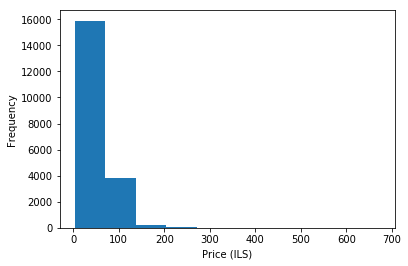

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(train_df['price'])
plt.xlabel('Price (ILS)')
plt.ylabel('Frequency')
plt.show()

3. We can see the price is skewed towards right. Fill in the code to see the histogram for Log(Price):

In [ ]:
import numpy as np

### YOUR CODE HERE ###

You can see the distribution of Log(Price) is much more symmetric, and therefore this is the metric we will model.

4. We want to model a shirt's price by its title, let's look at some of those:

In [8]:
train_df[['title']].head()

,title
0,Boden Boy's Pirate Battle Short Sleeve Graphic...
1,"NEW Faux Real Boy's Shirt 14/16 White, Black, ..."
2,Cherokee Pollo Shirt Boys M (8-10) Green Half ...
3,Volcom Kids El Rancho S/S Woven (Ultramarine) ...
4,IZOD Little Boys Short Sleeve Pique Polo Red s...


We can see these include lower/uppercase letters, non-alphanumeric characters, important words like "new", probably unimportant words like "shirt", size words like "M", Brand words like "IZOD", so-called [Stop Words](https://en.wikipedia.org/wiki/Stop_words) like "the" and more. Furthermore words like "boy", "boys", "boy's" should may be treated as the same word.

Going to into all Text Mining techniques of incorporating all of these insights for building a better model, is out of this assignment scope. For now just keep in mind the Bag Of Words (BOW) approach might be too simplistic for a good Text model. After all, a model which is "aware" a shirt is of brand "Ralph Lauren" is probably a better model.

5. Let's start with only the 10 most common words in the titles, after ignoring Stop Words like "a" and "the". The raw count for each word will be a single variable/feature/predictor in our model.

    To get the raw count of each word in the training images titles we'll use sklearn's [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) class:

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words = 'english')

train_dtm = vectorizer.fit_transform(train_df['title'])

print('Document-Term-Matrix size: %d X %d' % train_dtm.shape)

Document-Term-Matrix size: 20000 X 10651


What happened here?

* We instantiated a `CountVectorizer` object called `vectorizer`, specifying we do not want to count English Stop Words.
* Then we `fit_transform`ed this object to the `train_df` titles.
* We got a "Document-Term" sparse matrix `train_dtm` of 20K "documents" (rows) X ~10K "words", where the documents are actually our 20K titles, and the words are all the "tokens" found by `CountVectorizer` default definitions (look them up!)
* The entry `train_dtm[i, j]` means the count of word `j` in title `i`

Now let's get the top 10 words:

In [23]:
sum_words = train_dtm.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
top_10_words = words_freq[:10]
print(top_10_words)

[('shirt', 15393), ('nwt', 6857), ('size', 6841), ('girls', 6445), ('short', 5571), ('sleeve', 5436), ('boys', 5200), ('new', 4809), ('tee', 4657), ('youth', 4211)]


What happened here?

* We summed `train_dtm` count for each word (column), getting `sum_words`
* Iterated over the `vocabulary_` dictionary (member of the `vectorizer` object) to get a list of (word, freq) tuples in `word_freqs`
* Sorted them from top to bottom
* Got the top 10 words and put them in `top_10_words`

Notice these words might not be that imformative in predicting the price (the word "shirt" appears in 75% of titles!) but that's our current strategy.

6. We actually have all we need to do linear regression. `np.log(train_df['price'])` is our `y` explained variable, and if we filter `dtm_train` to just the relevant columns this is in fact our `X` matrix of explanatory variables.

    But in order for you to see that's it is possible to use `CountVectorizer` with a pre-given vocabulary list we'll do it from the start, now we know the top 10 words:

In [24]:
top_10_words = [x[0] for x in top_10_words]

vectorizer = CountVectorizer(stop_words = 'english', vocabulary = top_10_words)

X_train = vectorizer.fit_transform(train_df['title'])

print('X_train size: %d X %d' % X_train.shape)

X_train size: 20000 X 10


7. To fit a linear regression model to our data we'll use sklearn's [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) class:

In [26]:
from sklearn.linear_model import LinearRegression

mod = LinearRegression()
mod.fit(X_train, np.log(train_df['price']))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Get the regression coefficients (notice we use `vectorizer.get_feature_names()` not `top_10_words`):

In [31]:
print('intercept: %.2f' % mod.intercept_)
for i, w in enumerate(vectorizer.get_feature_names()):
    print('%s: %.2f' % (w, mod.coef_[i]))

intercept: 3.85
shirt: -0.01
nwt: -0.01
size: -0.10
girls: 0.01
short: -0.11
sleeve: 0.08
boys: 0.05
new: -0.03
tee: -0.03
youth: 0.16


Fit the model to the test set:

In [33]:
vectorizer_test = CountVectorizer(stop_words = 'english', vocabulary = top_10_words)
X_test = vectorizer_test.fit_transform(test_df['title'])
y_pred = mod.predict(X_test)

See a plot of predicted vs. true test values:

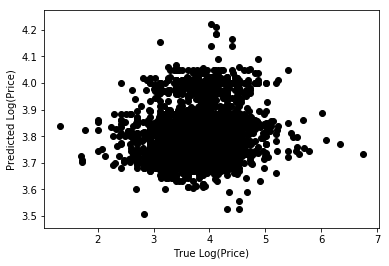

In [38]:
y_test = np.log(test_df['price'])
plt.scatter(y_test, y_pred,  color='black')
plt.xlabel('True Log(Price)')
plt.ylabel('Predicted Log(Price)')
plt.show()

As expected this doesn't look good. Get the MSE and R squared:

In [40]:
from sklearn.metrics import mean_squared_error, r2_score

print('Test MSE: %.2f' % mean_squared_error(y_test, y_pred))
print('R Squared: %.2f' % r2_score(y_test, y_pred))

Test MSE: 0.23
R Squared: 0.04


8. Not that with such a poor model we need this - some basic diagnostics is always in place. Complete the following code to plot a residuals plot showing test residuals vs. the test Log(Price):

In [43]:
resid = y_pred - y_test
### YOUR CODE HERE ###

Do you understand how with such a bad model you got this plot?

9. It's time to get all words!

    But wait, maybe not *all* words. Let's use `CountVectorizer`'s paramter `min_df` ("minimum document frequency") specifying we want a word to appear in the model only if it appears in say at least 10 out of 20K (so: 0.0005 of documents).

In [46]:
vectorizer = CountVectorizer(stop_words = 'english', min_df = 0.0005)

X_train = vectorizer.fit_transform(train_df['title'])

print('X_train size: %d X %d' % X_train.shape)

X_train size: 20000 X 1618


Repeat all of the above with the new `X_train` (except for printing all coefficients!).

Notice how we define `vectorizer_test` with `vectorizer`'s words (why).

You should get (not amazing but) much better results (plots, MSE and R-Squared).

In [47]:
mod = LinearRegression()
mod.fit(X_train, np.log(train_df['price']))
vectorizer_test = CountVectorizer(stop_words = 'english', vocabulary = vectorizer.get_feature_names())
X_test = vectorizer_test.fit_transform(test_df['title'])
### YOUR CODE HERE ###

10. Can Random Forest regressor perform better (this could take some time, we're not using "only" 20% of data here)?

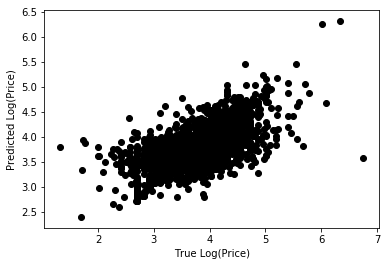

Test MSE: 0.12
R Squared: 0.49


In [60]:
from sklearn.ensemble import RandomForestRegressor

mod = RandomForestRegressor(n_estimators = 100)
mod.fit(X_train, np.log(train_df['price']))
y_pred = mod.predict(X_test)

plt.scatter(y_test, y_pred,  color='black')
plt.xlabel('True Log(Price)')
plt.ylabel('Predicted Log(Price)')
plt.show()

print('Test MSE: %.2f' % mean_squared_error(y_test, y_pred))
print('R Squared: %.2f' % r2_score(y_test, y_pred))

Much better :)